In [ ]:
# helper functions
import skimage
import cv2
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np

def load_coco_image_and_annotations(coco, images_dir, image_identifier, by_filename=True):
    """
    Load image and annotations from COCO dataset.

    Args:
        coco: COCO object initialized with annotations.
        images_dir: Path to image directory.
        image_identifier: Filename (str) or image ID (int).
        by_filename: If True, image_identifier is filename; else image ID.

    Returns:
        image (numpy array), annotations (list of dict), image_info (dict)
    """
    if by_filename:
        # Find image info by filename
        img_info = None
        for img_id in coco.getImgIds():
            info = coco.loadImgs(img_id)[0]
            if info['file_name'] == image_identifier:
                img_info = info
                break
        if img_info is None:
            raise ValueError(f"Image {image_identifier} not found in dataset.")
    else:
        # Load image info by ID
        img_info = coco.loadImgs(image_identifier)[0]

    # Load image
    img_path = os.path.join(images_dir, img_info['file_name'])
    image = skimage.io.imread(img_path)
    if image is None:
        raise FileNotFoundError(f"Image file {img_path} not found or cannot be read.")

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], iscrowd=None)
    annotations = coco.loadAnns(ann_ids)

    return image, annotations, img_info


def plot_image_with_bboxes(image, annotations, category_id_to_name=None):
    """
    Plot image with bounding boxes from COCO annotations.
    
    Args:
        image: numpy array or PIL image, the image to plot.
        annotations: list of COCO annotation dicts, each must have 'bbox' and optionally 'category_id'.
                     bbox format: [x_min, y_min, width, height]
        category_id_to_name: dict mapping category_id to category name (optional, for legend).
        
    Displays:
        Image with bounding boxes in different colors.
    """
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap='gray')
    # ax.axis('off')
    
    # Use a colormap with enough distinct colors
    num_boxes = len(annotations)
    # Use tab20 colormap for up to 20 distinct colors, or hsv for more
    cmap = plt.get_cmap('tab20', num_boxes if num_boxes > 0 else 1)
    
    for i, ann in enumerate(annotations):
        bbox = ann['bbox']
        x, y, w, h = bbox
        color = cmap(i % cmap.N)
        
        # Draw rectangle
        rect = Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Optionally add category name text
        if category_id_to_name and 'category_id' in ann:
            cat_name = category_id_to_name.get(ann['category_id'], str(ann['category_id']))
            ax.text(x, y - 5, cat_name, color=color, fontsize=12, weight='bold', backgroundcolor='white')
    
    plt.tight_layout()
    plt.show()



def crop_image(image, annotations):
    """
    Crop objects from an image based on COCO annotations, save cropped images,
    and save updated annotations including cropped filenames to a JSON file.

    Args:
        image_path (str): Path to the original image.
        annotations (list of dict): List of COCO annotation dicts for this image.
            Each dict must contain 'bbox', 'image_id', and 'id'.
        save_dir (str): Directory to save cropped images and json.

    Returns:
        None (saves cropped images and JSON annotation file)
    """
    cropped_imgs = []

    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = map(int, bbox)

        # Clip bbox to image boundaries
        x_end = min(x + w, image.shape[1])
        y_end = min(y + h, image.shape[0])
        x = max(x, 0)
        y = max(y, 0)

        cropped = image[y:y_end, x:x_end]
        cropped_imgs.append(cropped)
        # Copy original annotation and add cropped filename
    return cropped_imgs, annotations


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[{'image_id': 0, 'id': 0, 'category_id': 0, 'bbox': [434, 219, 48, 36], 'area': 4964, 'iscrowd': 0}, {'image_id': 0, 'id': 1, 'category_id': 0, 'bbox': [325, 290, 42, 38], 'area': 4964, 'iscrowd': 0}]
{'id': 0, 'file_name': 'Macros_Plate_15_image_0_patch_0_6.jpg', 'height': 6240, 'width': 6940, 'annotator': 'B'}


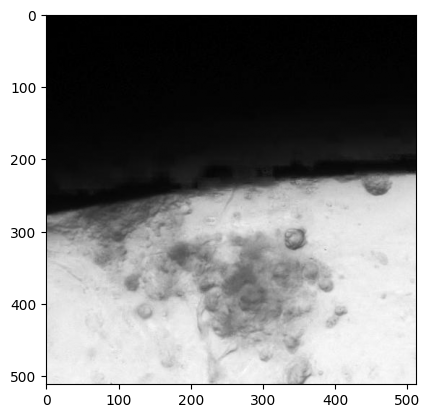

In [41]:
# load a image
%matplotlib inline
import matplotlib.pyplot as plt
import pycocotools
import pycocotools.coco
import skimage

IMG_DIR = r"../multi_org_val/val"
ANNO_PTH = r"../multi_org_val/val.json"

imfname = [fname for fname in os.listdir(IMG_DIR) if fname.endswith('.jpg')][0]
dataset = pycocotools.coco.COCO(annotation_file=ANNO_PTH)
first_img, first_img_anno, first_img_info = load_coco_image_and_annotations(dataset, IMG_DIR, imfname)


plt.imshow(first_img, cmap='gray')
print(first_img_anno)
print(first_img_info)


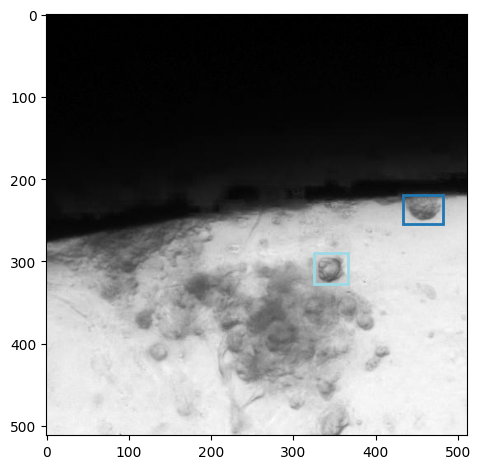

In [45]:
# plot the bounding box on the image
plot_image_with_bboxes(first_img, first_img_anno)

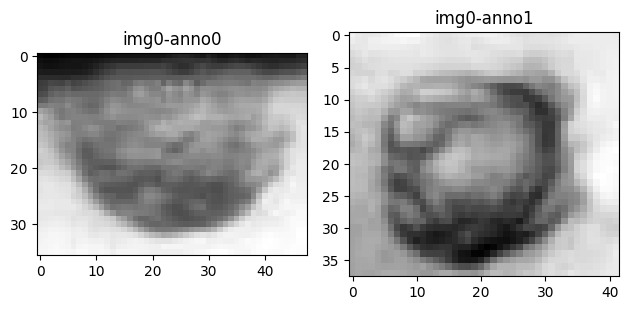

In [48]:
# crop out organoids
cropped, anno = crop_image(first_img, first_img_anno)

fig, axes = plt.subplots(1, len(cropped))

for crp, an, ax in zip(cropped, anno, axes):
    ax.imshow(crp, cmap='gray')
    ax.set_title(f"img{an['image_id']}-anno{an['id']}")
plt.tight_layout()

1.0


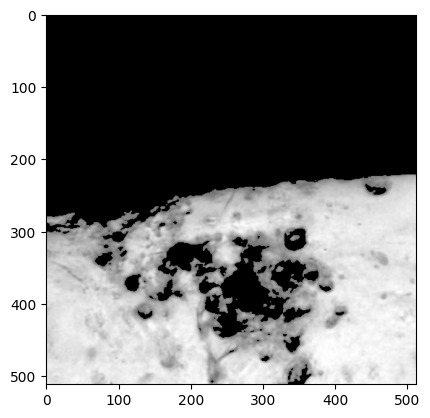

In [88]:
from skimage import io, color, filters, measure,exposure, morphology
# Thresholding
image = first_img

image = filters.gaussian(image, sigma=1)

image = exposure.equalize_adapthist(image)

plt.imshow(image, cmap='gray')
thresh = filters.threshold_otsu(image)
binary = image > thresh
# plt.imshow(binary)
print(image.max())
processed = (image * (binary))
plt.imshow(processed, cmap='gray')
# Morphological cleaning
cleaned = morphology.remove_small_objects(binary, min_size=100)

In [129]:
mask_file_location = r"D:\OneDrive - Advanced Biomedical Instrumentation Limited\Projects\Organoids\multi_org_val\analysis example\Macros_Plate_4_image_0_patch_1_4_seg.npy"
image_file_location = r"D:\OneDrive - Advanced Biomedical Instrumentation Limited\Projects\Organoids\multi_org_val\analysis example\Macros_Plate_4_image_0_patch_1_4.jpg"

In [1]:
import numpy as np

image = np.load(mask_file_location, allow_pickle=True).item()

NameError: name 'mask_file_location' is not defined

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb

def plot_mask_overlay(img, masks, alpha=0.5):
    """
    Overlay labeled mask on original image with different colors per ROI.

    Parameters:
    - img: 2D grayscale or 3D RGB image (numpy array)
    - masks: 2D integer array with labeled ROIs (0=background)
    - alpha: float, transparency of mask overlay (0=transparent, 1=opaque)

    Returns:
    - None (displays the plot)
    """
    # If img is grayscale 2D, convert to RGB for color overlay
    if img.ndim == 2:
        img_rgb = np.stack([img]*3, axis=-1)
    else:
        img_rgb = img.copy()

    # Generate colored label overlay with background transparent
    mask_overlay = label2rgb(masks, image=img_rgb, bg_label=0, alpha=alpha, kind='overlay')

    plt.figure(figsize=(8,8))
    plt.imshow(mask_overlay)
    plt.axis('off')
    plt.title('Mask overlay on original image')
    plt.show()


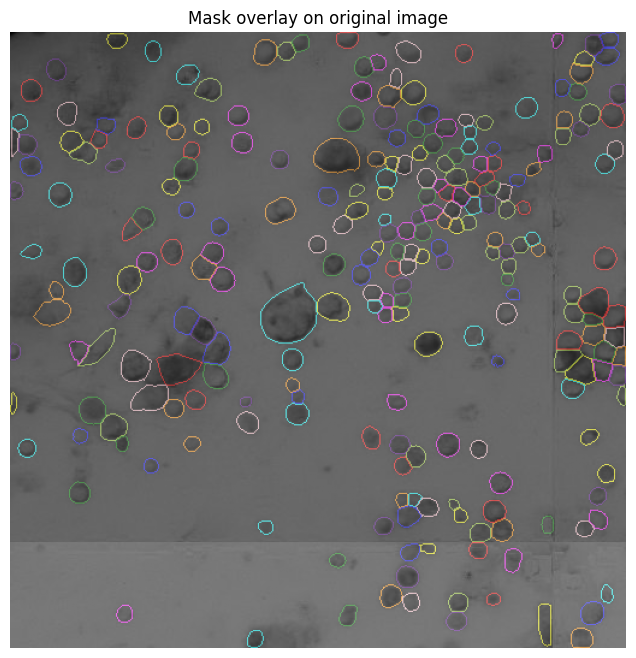

In [ ]:
img = skimage.io.imread(image_file_location)
plot_mask_overlay(img,image['outlines'])

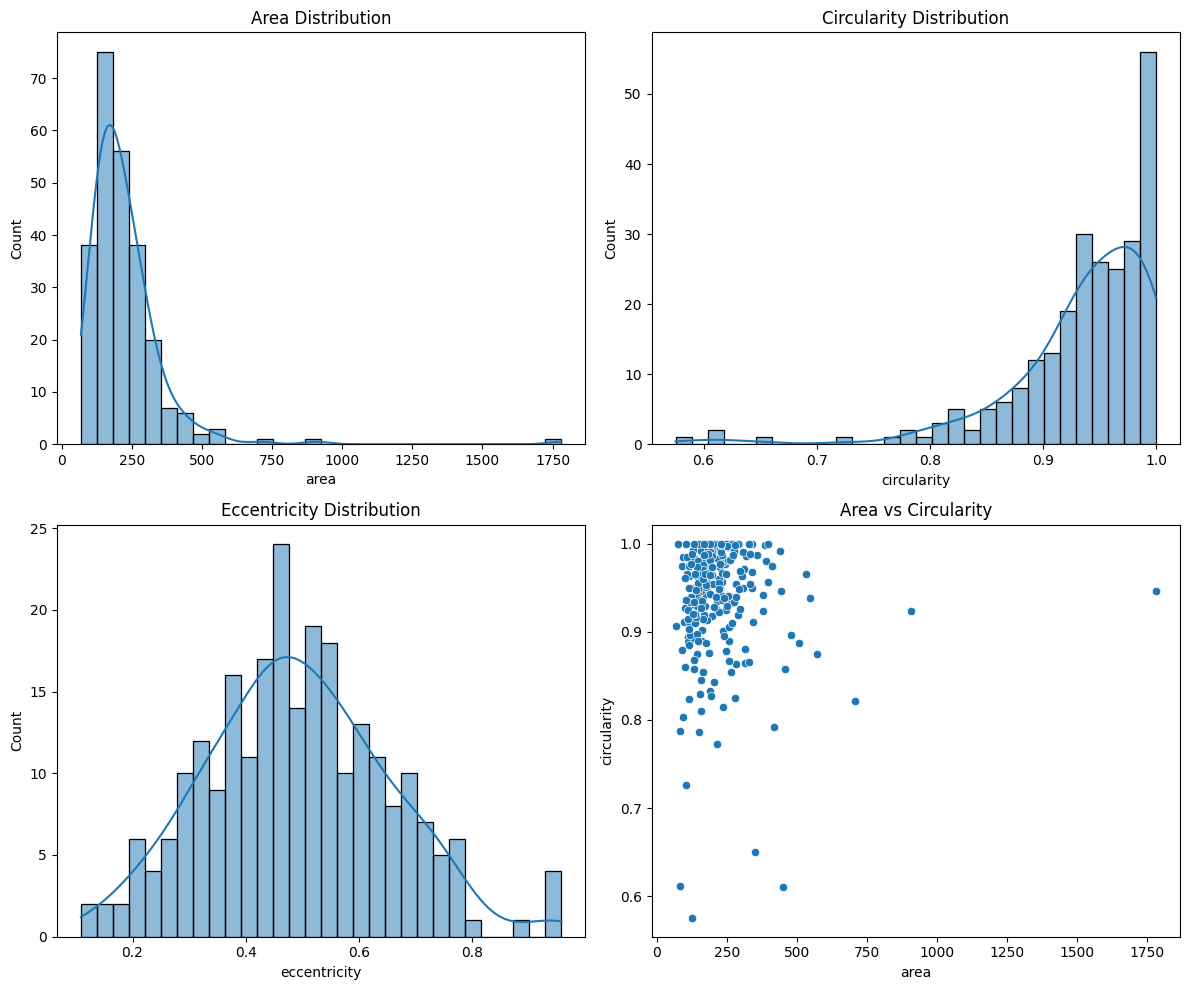

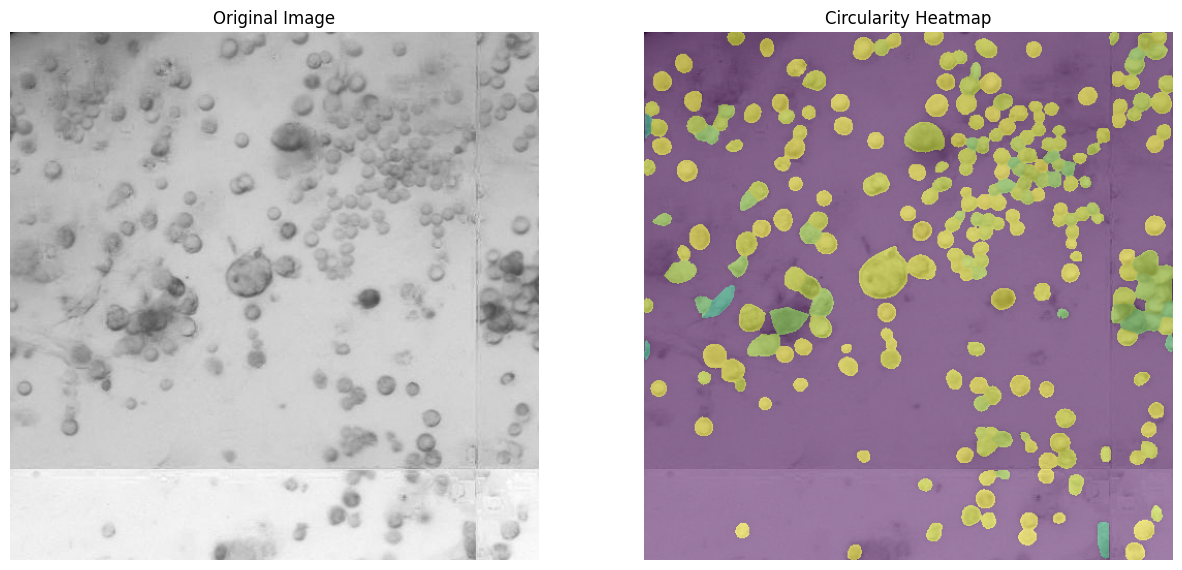

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import regionprops_table, label
from skimage.color import label2rgb
from skimage import measure
import seaborn as sns

def calculate_organoid_metrics(masks):
    """Calculate organoid metrics from labeled masks"""
    # Calculate region properties
    props = measure.regionprops(masks)
    
    # Initialize metrics dictionary
    metrics = {
        'label': [],
        'area': [],
        'eccentricity': [],
        'circularity': [],
        'perimeter': []
    }
    
    for prop in props:
        if prop.area < 10:  # Skip small artifacts
            continue
            
        metrics['label'].append(prop.label)
        metrics['area'].append(prop.area)
        metrics['eccentricity'].append(prop.eccentricity)
        metrics['perimeter'].append(prop.perimeter_crofton)
        
        # Calculate circularity: 1 = perfect circle
        circularity = (4 * np.pi * prop.area) / (prop.perimeter_crofton ** 2) if prop.perimeter_crofton > 0 else 0
        metrics['circularity'].append(min(circularity, 1.0))  # Cap at 1.0
    
    return pd.DataFrame(metrics)

def plot_metric_statistics(metrics_df):
    """Plot distribution statistics for organoid metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    sns.histplot(metrics_df['area'], bins=30, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Area Distribution')
    
    sns.histplot(metrics_df['circularity'], bins=30, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Circularity Distribution')
    
    sns.histplot(metrics_df['eccentricity'], bins=30, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Eccentricity Distribution')
    
    sns.scatterplot(x='area', y='circularity', data=metrics_df, ax=axes[1, 1])
    axes[1, 1].set_title('Area vs Circularity')
    
    plt.tight_layout()
    plt.show()

def create_metric_heatmap(img, masks, metrics_df, metric='area'):
    """Create heatmap overlay for specified metric"""
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    else:
        img = img.copy()
    # Create normalized metric array
    metric_map = np.zeros_like(masks, dtype=float)
    max_val = metrics_df[metric].max()
    
    for _, row in metrics_df.iterrows():
        label_val = row['label']
        metric_val = row[metric]
        metric_map[masks == label_val] = metric_val / max_val
    
    # Create heatmap overlay
    heatmap = plt.cm.viridis(metric_map)[..., :3]  # Use viridis colormap
    overlay = img * 0.5 + heatmap * 0.5
    
    # Plot results
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    ax[1].imshow(overlay)
    ax[1].set_title(f'{metric.capitalize()} Heatmap')
    ax[1].axis('off')
    
    plt.show()

# Usage example
# Load your data
  # Original image
seg_data = image
masks = seg_data['masks']  # Labeled masks

# Calculate metrics
metrics_df = calculate_organoid_metrics(masks)

# Visualize statistics
plot_metric_statistics(metrics_df)

# Create heatmap overlay (choose metric: 'area', 'circularity', 'eccentricity')
create_metric_heatmap(img/255, masks, metrics_df, metric='circularity')


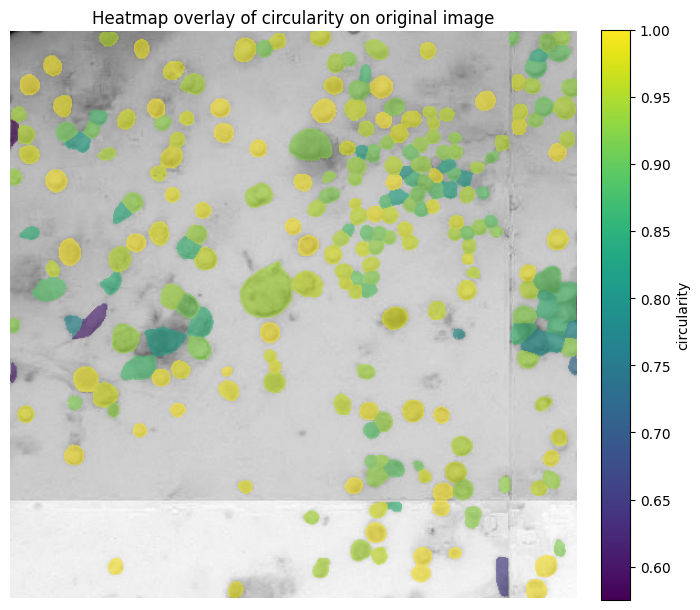

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, viridis
from skimage.measure import regionprops

def plot_metric_heatmap_on_image(img, masks, metrics_df, metric='area', alpha=0.6):
    """
    Overlay a metric heatmap on the original image as background.
    Only the segmented ROIs are colored by the metric; background is transparent.
    
    Parameters:
    - img: 2D grayscale or 3D RGB image (numpy array)
    - masks: 2D labeled mask array (integers, 0=background)
    - metrics_df: DataFrame with columns ['label', metric]
    - metric: string, metric column to visualize
    - alpha: float, transparency of the heatmap overlay on ROIs
    
    Displays the plot with original image as background and heatmap overlay on ROIs.
    """
    # Normalize metric values to [0,1]
    norm = Normalize(vmin=metrics_df[metric].min(), vmax=metrics_df[metric].max())
    cmap = viridis
    
    # Create empty RGBA overlay image
    overlay = np.zeros((*masks.shape, 4), dtype=float)  # RGBA
    
    # Map each ROI label to a color based on its metric value
    label_to_metric = dict(zip(metrics_df['label'], metrics_df[metric]))
    
    for label_val, metric_val in label_to_metric.items():
        color = cmap(norm(metric_val))  # RGBA tuple
        mask = (masks == label_val)
        overlay[mask, :3] = color[:3]  # RGB
        overlay[mask, 3] = alpha       # Alpha channel only on ROI pixels
    
    # Prepare background image as RGB float in [0,1]
    if img.ndim == 2:
        background = np.stack([img]*3, axis=-1)
    else:
        background = img.copy()
    background = background.astype(float)
    if background.max() > 1.0:
        background /= 255.0  # scale if needed
    
    # Alpha blending: out = alpha*overlay + (1-alpha)*background on ROI pixels
    combined = background.copy()
    alpha_mask = overlay[..., 3]
    for c in range(3):
        combined[..., c] = (overlay[..., c] * alpha_mask) + (background[..., c] * (1 - alpha_mask))
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(combined)
    ax.axis('off')
    ax.set_title(f'Heatmap overlay of {metric} on original image')
    
    # Add colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(metric)
    
    plt.show()

plot_metric_heatmap_on_image(img, masks, metrics_df, metric='circularity', alpha=0.6)

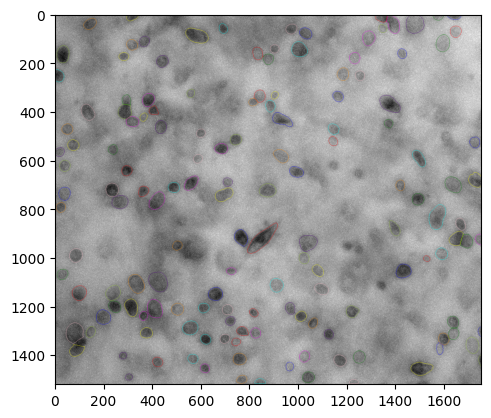

In [20]:
import skimage
import matplotlib.pyplot as plt
from cell_seg_analysis import plot_mask_overlay
import numpy as np
image_file = r'C:\Users\User\Desktop\test.png'
segmentation_file = r'C:\Users\User\Desktop\test_seg.npy'
results_dir = r'C:\Users\User\Desktop\segmentation_analysis'
img = skimage.io.imread(image_file, as_gray=True)
seg_data = np.load(segmentation_file, allow_pickle=True).item()
# if img.ndim == 2:
#     img = np.stack([img] * 3, axis=-1)
# elif img.shape[-1] == 4: # RGBA images
#     img = skimage.color.rgba2rgb(img)
# else:
#     img = img.copy()
img = (img - img.min())/(img.max()-img.min())
img = skimage.color.label2rgb(seg_data['outlines'],img, alpha=1, bg_color = None, )
plt.imshow(img)